# Food101 Challenge

**Task:**<br>Food 101 is a labelled data set with 101 different food classes. Each food class contains 1000 images. Using the data provided,  a Machine Learning Model that can classify 3 classes in Food 101 dataset is created.

**The Setting:**
<br>**Classes: **(Apple_pie, Baby_back_ribs, Baklava)
<br>**Epoches: **100
<br>**Batch_size:** 64

In [3]:
# 코드 실행에 필요한 library들 import
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc
import time

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os

# # 하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# float type > 소수점 3자리 수 까지 출력
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 컬럼 생략 안함
pd.set_option('max_columns', None)

# 아래 코드에서 100%를 본인이 원하는 비율로 조정하여, 가로로 넓게 코드작성이 가능하고, 데이터를 보는데 쾌적한 환경을 조성할 수 있음
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Get the paths of the images and the train-test image files for each category

In [71]:
# find file paths
# glob 함수는 사용자가 제시한 조건에 맞는
# 파일명을 리스트 형식으로 반환
food = ['apple_pie','baby_back_ribs', 'baklava']
f_apple = glob.glob('../input/food102/food101/food101/train/'+food[0]+'/*')
f_baby = glob.glob('../input/food102/food101/food101/train/'+food[1]+'/*')
f_baklava = glob.glob('../input/food102/food101/food101/train/'+food[2]+'/*')
f_test = glob.glob('../input/food102/food101/food101/test/test/*')
# f_apple_test = glob.glob('../input/food102/food101/food101/test/'+food[0]+'/*')
# f_baby_test = glob.glob('../input/food102/food101/food101/test/'+food[1]+'/*')
# f_baklava_test = glob.glob('../input/food102/food101/food101/test/'+food[2]+'/*')
# total 1000 files for each category
print('Number of images per class:\n\t\ttrain\t \nApple_pie:\t{}\nBaby_pork_ribs:\t{}\nBaklava:\t{}\n\nTest:{}'
      .format(len(f_apple),len(f_baklava),len(f_baby),len(f_test)))

Number of images per class:
		train	 
Apple_pie:	1000
Baby_pork_ribs:	1000
Baklava:	1000

Test:1


# EDA

#### Let's get an idea of the images of the 3 categories. As we see here, the quality of the images are not very good: with different background (noise), different lightings and even wrong labels (e.g. empty plate in the first pic of the baklava, missing apple pie in the last apple pie pic).

time: 0.2665290832519531


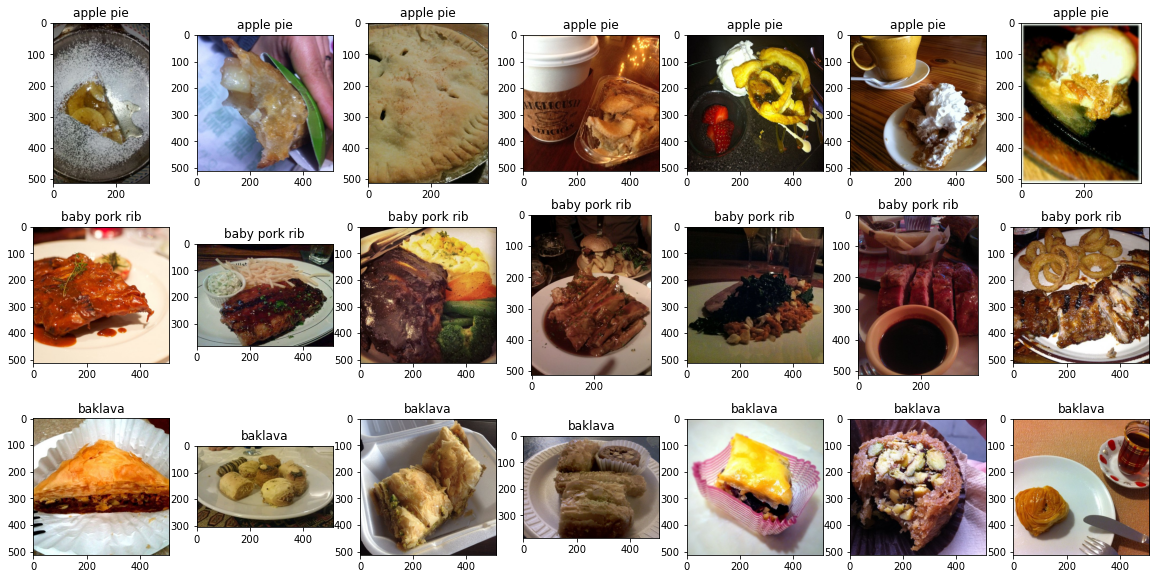

In [5]:
# preview some images of each class
n = 7
fig, axes = plt.subplots(3,n,figsize=(20,10))
# 행=3, 열=n, index=figsize
start_time = time.time()
# imshow는 원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림
# imread 이미지 읽어오는 함수
for i in range(n):
    axes[0, i].imshow(plt.imread(f_apple[i]))
    axes[0, i].set_title('apple pie')
    axes[1, i].imshow(plt.imread(f_baby[i]))
    axes[1, i].set_title('baby pork rib')
    axes[2, i].imshow(plt.imread(f_baklava[i]))
    axes[2, i].set_title('baklava')
print(f'time: {time.time() - start_time}')

#### The images are of different sizes and aspect ratio, with at least one side of 512 pixels.

time: 37.01530981063843


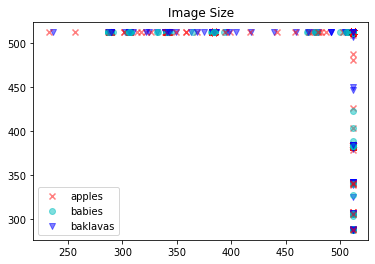

In [6]:
start_time = time.time()
# 이미지의 크기 반환 후 산점도로 시각화(이미지 크기 확인)
for i in range(len(f_apple)):
    h1,w1,c1 = plt.imread(f_apple[i]).shape
    h2,w2,c2 = plt.imread(f_baby[i]).shape
    h3,w3,c3 = plt.imread(f_baklava[i]).shape
    plt.scatter(h1,w1,c='r',marker='x',alpha=0.5)
    plt.scatter(h2,w2,c='c',marker='o',alpha=0.5)
    plt.scatter(h3,w3,c='b',marker='v',alpha=0.5)
print(f'time: {time.time() - start_time}')
plt.title('Image Size')
plt.legend(('apples','babies','baklavas'))

# Data Augmentation

#### In order to avoid overfitting problem and to expand the dataset. Image data generator from Keras is used for image tranformation.

In [7]:
# ImageDataGenerator 클래스(케라스에서 제공)
# 실시간 데이터 증강을 사용해서 텐서 이미지 데이터 배치를 생성합니다.
# 데이터에 대해 (배치 단위로) 루프가 순환됩니다.

train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
                                #rescale : 크기 재조절 인수
                                # 데이터를 주어진 값으로 곱함

        
# flow_from_directory 함수
# 첫번째 인자 : 이미지의 경로를 지정
# target_size : 패치 이미지 크기를 지정. 폴더에 있는 원본 이미지
#               크기가 다르더라도 target_size에 지정된 크기로
#               자동 조절됩니다.
# batch_size : 배치 크기를 지정합니다.
        
train_generator = train_datagen.flow_from_directory(
        "../input/food102/food101/food101/train",
        target_size=(224,224),
        batch_size=64)

test_datagen = ImageDataGenerator(rescale=1/255) # just rescale to [0-1] for testing set
test_generator = test_datagen.flow_from_directory(
        "../input/food102/food101/food101/test",
        target_size=(224,224),
        batch_size=64)



Found 3000 images belonging to 3 classes.
Found 26 images belonging to 1 classes.


#### Just to make sure the image generator is working and the transformation is acceptable.

time: 1.3747143745422363


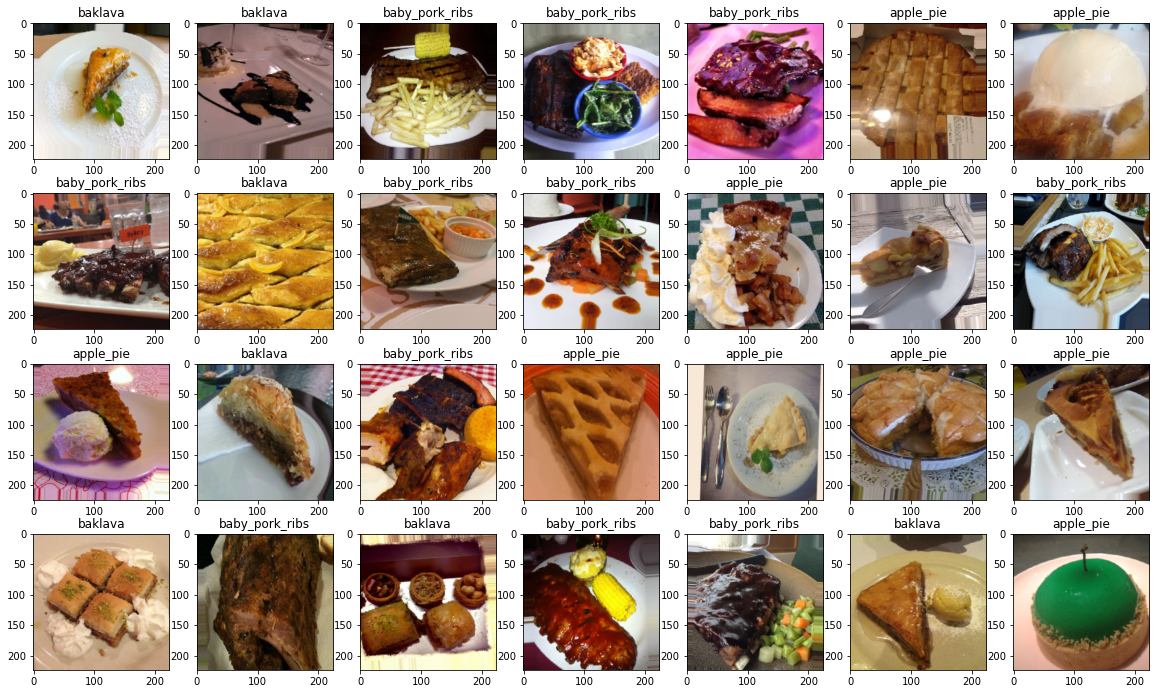

In [8]:
# preview images from train generator
r = 4; c = 7
n=0
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava'}

start_time = time.time()

# numpy.argmax는 다차원 배열의 경우에 차원에 따라
# 가장 큰 값의 인덱스들을 반환해주는 함수입니다.

for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break
print(f'time: {time.time() - start_time}')

# Modelling

In [9]:
# 합성곱 신경망 구성하는 과정

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

In [11]:
# fit_generator : 파이썬 생성기가 배치 단위로 생성한 데이터에 대해서
#                 모델을 학습시킵니다.
# 
# 인수
# generator : 다중 처리 과정을 사용하는 경우 데이터 중복을 피하기
#             위한 생성기
# steps_per_epoch : 한 세대의 종료를 선언하고 다음 세대를 시작하기
#                   까지 generator에서 생성할 단계의 총 개수
# epochs : 모델을 학습시킬 세대의 수
# validation_data : 검증 데이터용(이 데이터에 대해서는 학습 x)
# validation_steps : 매 세대 정지하기 전 validation_data 생성기에서
#                    만들어 낼 단계(샘플 배치)의 총 개수

start_time = time.time()
history = model.fit_generator(train_generator,steps_per_epoch=2250/64,
                              validation_data=test_generator,validation_steps=750/64, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])
print(f'time: {time.time() - start_time}')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
36/35 [==============================] - ETA: -1s - loss: 1.1709 - accuracy: 0.3707WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 11.71875 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 3.71738, saving model to model.hdf5
36/35 [==============================] - 62s 2s/step - loss: 1.1709 - accuracy: 0.3707 - val_loss: 3.7174 - val_accuracy: 0.3077
Epoch 2/100
36/35 [==============================] - 62s 2s/step - loss: 1.0491 - accuracy: 0.4948
Epoch 3/100
36/35 [==============================] - 62s 2s/step - loss: 0.8917 - accuracy: 0.5551
Epoch 4/100
36/35 [==============================] - 63s 2s/step - loss: 0.8442 - accuracy: 0.5801
Epoch 5/100
36/35 [==============================] 

Epoch 16/100
36/35 [==============================] - 63s 2s/step - loss: 0.7115 - accuracy: 0.6442
Epoch 17/100
36/35 [==============================] - 63s 2s/step - loss: 0.6702 - accuracy: 0.6567
Epoch 18/100
36/35 [==============================] - 63s 2s/step - loss: 0.6769 - accuracy: 0.6411
Epoch 19/100
36/35 [==============================] - 63s 2s/step - loss: 0.6868 - accuracy: 0.6420
Epoch 20/100
36/35 [==============================] - 63s 2s/step - loss: 0.6836 - accuracy: 0.6616
Epoch 21/100
36/35 [==============================] - 63s 2s/step - loss: 0.6565 - accuracy: 0.6729
Epoch 22/100
36/35 [==============================] - 64s 2s/step - loss: 0.6616 - accuracy: 0.6725
Epoch 23/100
36/35 [==============================] - 65s 2s/step - loss: 0.6465 - accuracy: 0.6851
Epoch 24/100
36/35 [==============================] - 63s 2s/step - loss: 0.6301 - accuracy: 0.7073
Epoch 25/100
36/35 [==============================] - 65s 2s/step - loss: 0.6247 - accuracy: 0.7095


36/35 [==============================] - 64s 2s/step - loss: 0.5813 - accuracy: 0.7369
Epoch 32/100
36/35 [==============================] - 64s 2s/step - loss: 0.5698 - accuracy: 0.7452
Epoch 33/100
36/35 [==============================] - 63s 2s/step - loss: 0.5526 - accuracy: 0.7487
Epoch 34/100
36/35 [==============================] - 63s 2s/step - loss: 0.5814 - accuracy: 0.7352
Epoch 35/100
36/35 [==============================] - 63s 2s/step - loss: 0.5709 - accuracy: 0.7369
Epoch 36/100
36/35 [==============================] - 64s 2s/step - loss: 0.5636 - accuracy: 0.7487
Epoch 37/100
36/35 [==============================] - 63s 2s/step - loss: 0.5685 - accuracy: 0.7417
Epoch 38/100
36/35 [==============================] - 64s 2s/step - loss: 0.5405 - accuracy: 0.7569
Epoch 39/100
36/35 [==============================] - 63s 2s/step - loss: 0.5378 - accuracy: 0.7544
Epoch 40/100
36/35 [==============================] - 63s 2s/step - loss: 0.5666 - accuracy: 0.7365
Epoch 41/100


36/35 [==============================] - 64s 2s/step - loss: 0.5164 - accuracy: 0.7778
Epoch 48/100
36/35 [==============================] - 63s 2s/step - loss: 0.5012 - accuracy: 0.7848
Epoch 49/100
36/35 [==============================] - 67s 2s/step - loss: 0.5068 - accuracy: 0.7731
Epoch 50/100
36/35 [==============================] - 64s 2s/step - loss: 0.5100 - accuracy: 0.7795
Epoch 51/100
36/35 [==============================] - 64s 2s/step - loss: 0.5220 - accuracy: 0.7622
Epoch 52/100
36/35 [==============================] - 64s 2s/step - loss: 0.4704 - accuracy: 0.7975
Epoch 53/100
36/35 [==============================] - 64s 2s/step - loss: 0.4887 - accuracy: 0.7860
Epoch 54/100
36/35 [==============================] - 64s 2s/step - loss: 0.4712 - accuracy: 0.7979
Epoch 55/100
36/35 [==============================] - 64s 2s/step - loss: 0.4540 - accuracy: 0.8194
Epoch 56/100
36/35 [==============================] - 64s 2s/step - loss: 0.4708 - accuracy: 0.8044
Epoch 57/100


36/35 [==============================] - 63s 2s/step - loss: 0.4581 - accuracy: 0.7979
Epoch 63/100
36/35 [==============================] - 64s 2s/step - loss: 0.4509 - accuracy: 0.8121
Epoch 64/100
36/35 [==============================] - 65s 2s/step - loss: 0.4393 - accuracy: 0.8171
Epoch 65/100
36/35 [==============================] - 64s 2s/step - loss: 0.4473 - accuracy: 0.8030
Epoch 66/100
36/35 [==============================] - 64s 2s/step - loss: 0.4414 - accuracy: 0.8162
Epoch 67/100
36/35 [==============================] - 64s 2s/step - loss: 0.4244 - accuracy: 0.8236
Epoch 68/100
36/35 [==============================] - 64s 2s/step - loss: 0.4322 - accuracy: 0.8099
Epoch 69/100
36/35 [==============================] - 64s 2s/step - loss: 0.4237 - accuracy: 0.8267
Epoch 70/100
36/35 [==============================] - 64s 2s/step - loss: 0.4256 - accuracy: 0.8177
Epoch 71/100
36/35 [==============================] - 63s 2s/step - loss: 0.4113 - accuracy: 0.8153
Epoch 72/100


36/35 [==============================] - 64s 2s/step - loss: 0.4108 - accuracy: 0.8227
Epoch 79/100
36/35 [==============================] - 64s 2s/step - loss: 0.3963 - accuracy: 0.8423
Epoch 80/100
36/35 [==============================] - 64s 2s/step - loss: 0.4072 - accuracy: 0.8349
Epoch 81/100
36/35 [==============================] - 64s 2s/step - loss: 0.3608 - accuracy: 0.8528
Epoch 82/100
36/35 [==============================] - 64s 2s/step - loss: 0.3783 - accuracy: 0.8446
Epoch 83/100
36/35 [==============================] - 64s 2s/step - loss: 0.3730 - accuracy: 0.8458
Epoch 84/100
36/35 [==============================] - 64s 2s/step - loss: 0.4178 - accuracy: 0.8332
Epoch 85/100
36/35 [==============================] - 64s 2s/step - loss: 0.3609 - accuracy: 0.8480
Epoch 86/100
36/35 [==============================] - 64s 2s/step - loss: 0.3573 - accuracy: 0.8571
Epoch 87/100
36/35 [==============================] - 64s 2s/step - loss: 0.3833 - accuracy: 0.8524
Epoch 88/100


36/35 [==============================] - 64s 2s/step - loss: 0.3541 - accuracy: 0.8568
Epoch 94/100
36/35 [==============================] - 64s 2s/step - loss: 0.3414 - accuracy: 0.8624
Epoch 95/100
36/35 [==============================] - 64s 2s/step - loss: 0.3657 - accuracy: 0.8481
Epoch 96/100
36/35 [==============================] - 64s 2s/step - loss: 0.3655 - accuracy: 0.8490
Epoch 97/100
36/35 [==============================] - 64s 2s/step - loss: 0.3858 - accuracy: 0.8423
Epoch 98/100
36/35 [==============================] - 64s 2s/step - loss: 0.3475 - accuracy: 0.8550
Epoch 99/100
36/35 [==============================] - 64s 2s/step - loss: 0.3391 - accuracy: 0.8632
Epoch 100/100
36/35 [==============================] - 64s 2s/step - loss: 0.3399 - accuracy: 0.8628
time: 6648.609847545624


In [23]:
# # load weights from upload files
# model.load_weights('../input/model-v17/model_v17.hdf5')

# load weights from training with lowest val_loss
# model.load_weights('../working/model.hdf5')

KeyError: 'acc'

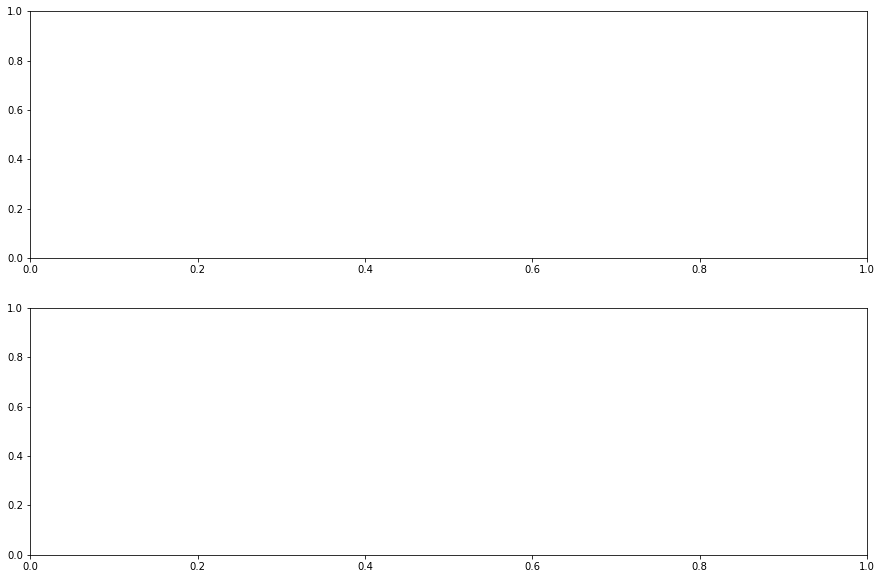

In [29]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['acc'],c='C2')
    ax[0].plot(history.history['val_acc'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

# Evaluate results

In [72]:
# create another generator for all test images in a single batch 
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        "../input/food102/food101/food101/test",
        target_size=(224,224),
        batch_size=750)

Found 1 images belonging to 1 classes.


In [73]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 0.0%


### Randomly check 5 predictions

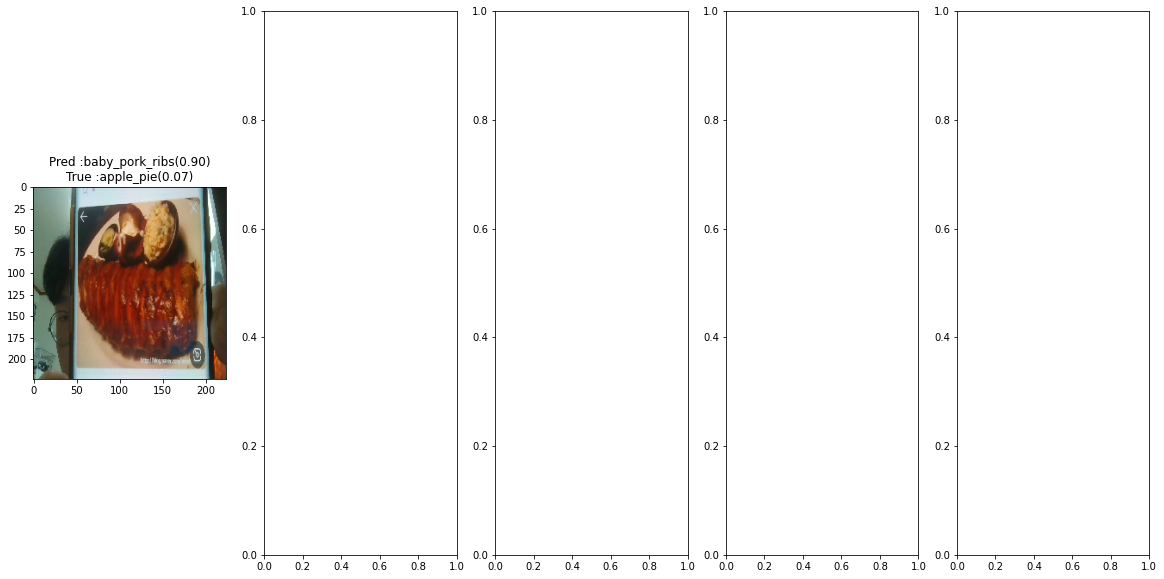

In [74]:
def delDuplicates():
    ind = np.random.randint(0,len(x_test),50)
    new_list = []
    for v in ind:
        if v not in new_list:
            new_list.append(v)
    return new_list[:5]
ind = delDuplicates()
f, ax=plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    ax[i].imshow(x_test[j])
    ax[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))


### Confusion Matrix

(1, 3)


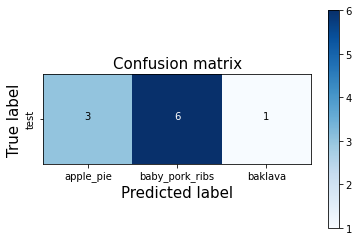

In [152]:
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['apple_pie','baby_pork_ribs','baklava']
    classes_test = ['test']
    plt.xticks([0,1,2], classes, fontsize=10)
    plt.yticks([0], classes_test, fontsize=10,rotation=90,verticalalignment="center")
    print(cm.shape)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)

data_matrix = np.array([confusion_matrix(y_label,y_pred)[0]])
plot_confusion_matrix(data_matrix)

### ROC Curve

In [137]:
import warnings
warnings.filterwarnings(action='ignore')

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under roc curve
fpr[0], tpr[0], _ = roc_curve(y_test[:, 0], y_pred_conf[:, 0]) # roc_curve function apply to binary class only
roc_auc[0] = auc(fpr[0], tpr[0])  # using the trapezoidal rule to get area under curve

In [148]:
fpr[0][0] = 0
fpr[0][1] = 0.5
fpr[0][2] = 1

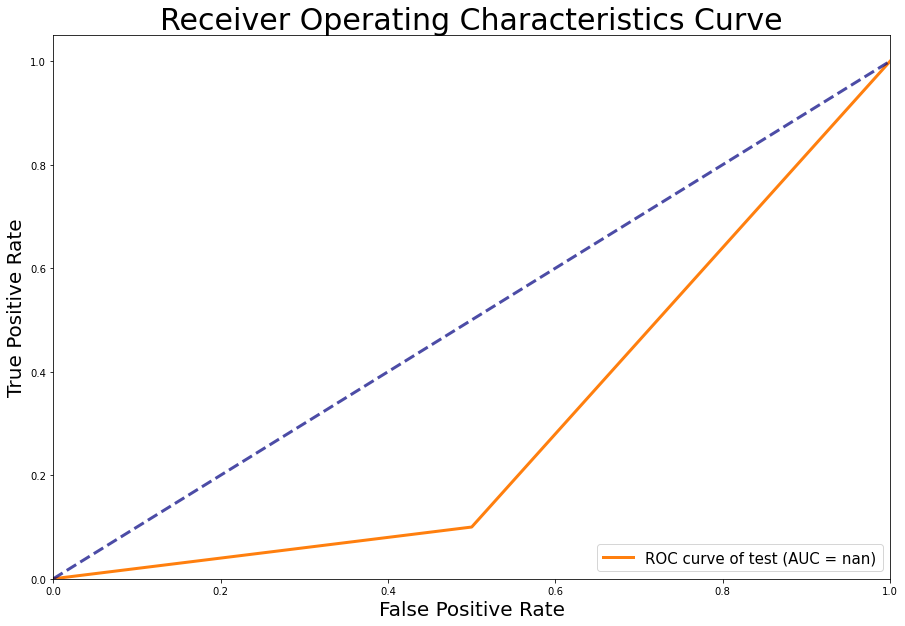

In [149]:
def plot_roc(fpr,tpr,roc_auc):
    plt.figure(figsize=(15,10))
    plt.plot(fpr[0], tpr[0], color='C1', lw=3, label='ROC curve of test (AUC = %0.2f)' % roc_auc[0])
#     plt.plot(fpr[1], tpr[1], color='C2', lw=3, label='ROC curve of baby_pork_ribs (AUC = %0.2f)' % roc_auc[1])
#     plt.plot(fpr[2], tpr[2], color='C3', lw=3, label='ROC curve of baklava (AUC = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--',alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Receiver Operating Characteristics Curve',fontsize=30)
    plt.legend(loc="lower right",fontsize=15)
    plt.show()

plot_roc(fpr,tpr,roc_auc)

### Inspect the predictions with wrong labels

In [150]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

IndexError: index 7 is out of bounds for axis 0 with size 7

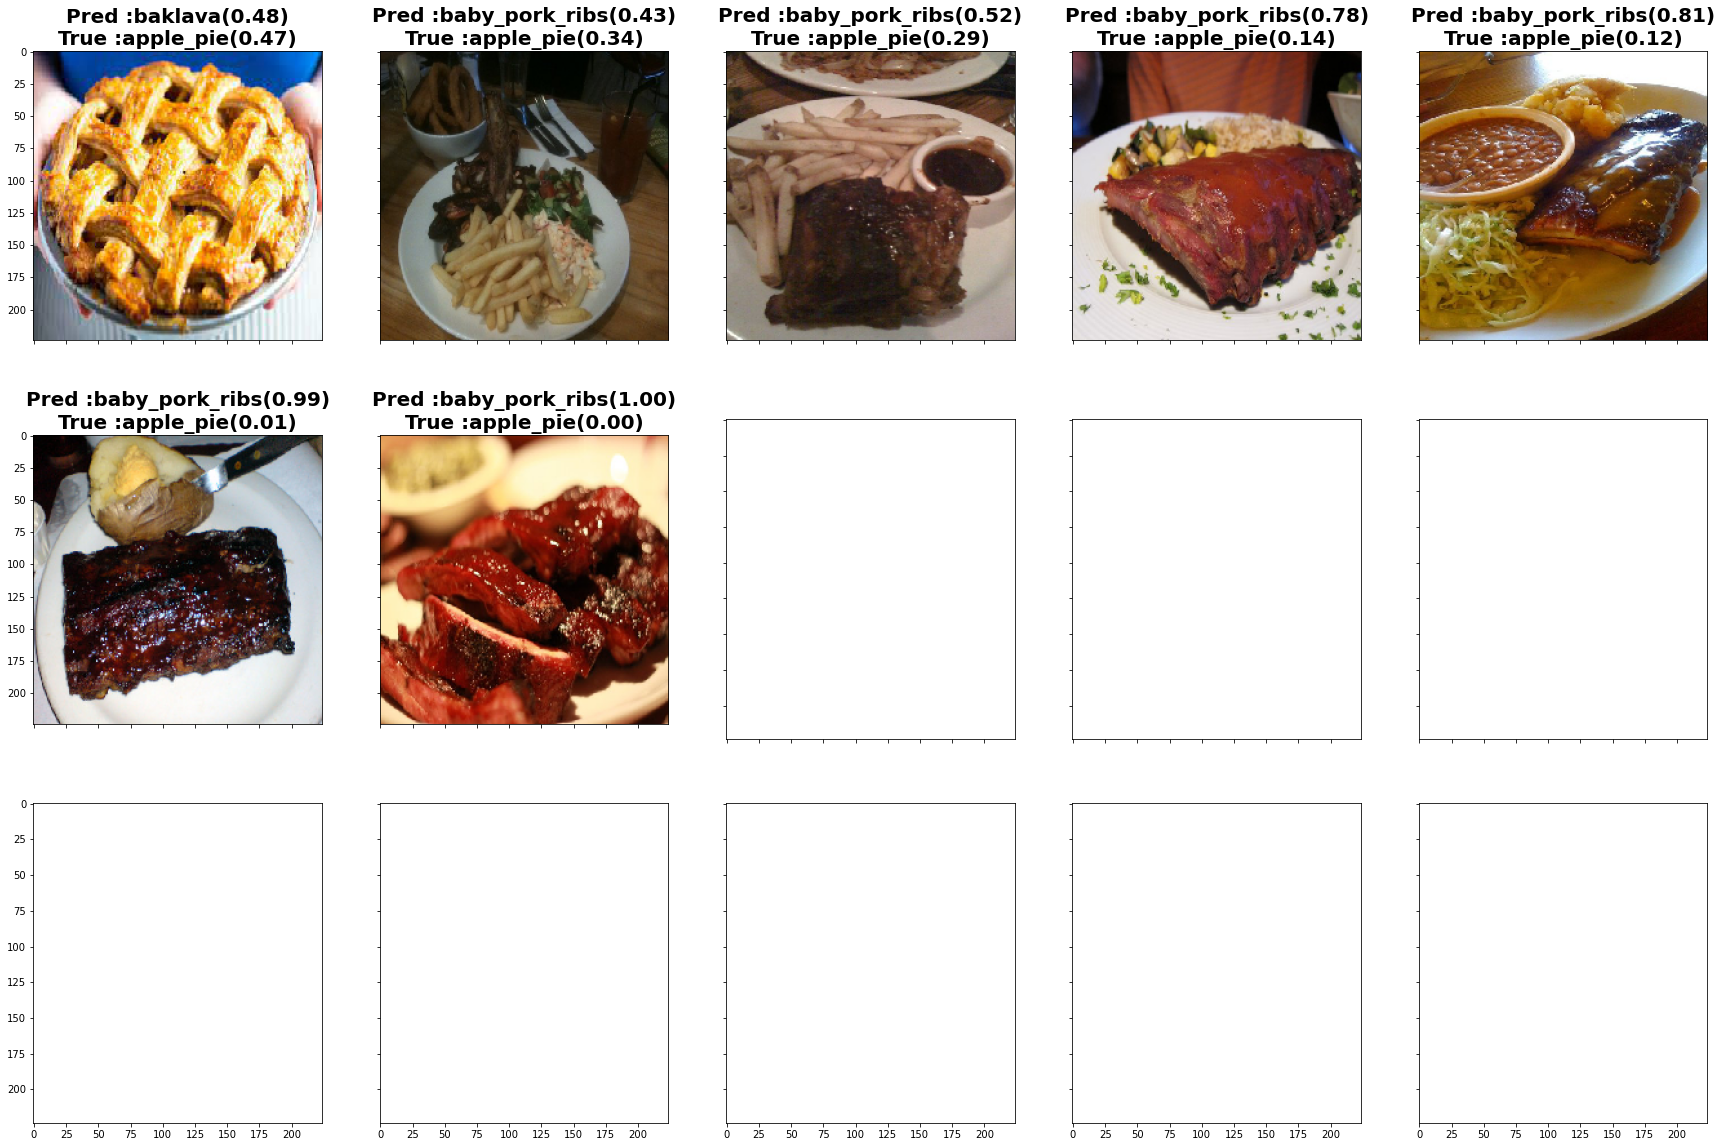

In [151]:
show_wrongest_label(x_test,y_test,y_pred_conf)